In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Comment out to use GPU instead of CPU
# tf.config.set_visible_devices([], 'GPU')

# DO NOT CHANGE SEED or all your answers will be wrong!
tf.keras.utils.set_random_seed(5)

# Facebook Graph Dataset Creation

In [2]:
# Facebook Graph Dataset
id='1jSuo8v4I0EUHFe_L_Z9WcHoym81h5QYy'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('musae_facebook_edges.csv')

id='1fWARzj2We5ihvzPn8oHEJkqhlNN5CKNl'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('musae_facebook_target.csv')

In [3]:
edges = pd.read_csv("musae_facebook_edges.csv")
display(edges.head())

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [4]:
targets_df = pd.read_csv('musae_facebook_target.csv')
targets_df.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [5]:
targets_df.page_type.value_counts()

page_type
government    6880
company       6495
politician    5768
tvshow        3327
Name: count, dtype: int64

# Construct Facebook Data Graph

In [6]:
def id_to_name(id):
    return targets_df[targets_df.id == id].page_name.values[0]

def name_to_id(name):
    return targets_df[targets_df.page_name == name].id.values[0]

### a. Create maximal subgraphs

In [7]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")
print("Original Number of Nodes: ", graph.number_of_nodes())
print("Original Number of Edges: ", graph.number_of_edges())
graph.remove_edges_from(nx.selfloop_edges(graph))

### Your Code Here

tiny_graph = nx.k_core(graph, k = 30)
print("\nTINY Number of Nodes: ", tiny_graph.number_of_nodes())
print("TINY Number of Edges: ", tiny_graph.number_of_edges())

small_graph = nx.k_core(graph, k = 15)
print("\nSmall Number of Nodes: ", small_graph.number_of_nodes())
print("Small Number of Edges: ", small_graph.number_of_edges())

Original Number of Nodes:  22470
Original Number of Edges:  171002

TINY Number of Nodes:  804
TINY Number of Edges:  24266

Small Number of Nodes:  4274
Small Number of Edges:  87148


In [8]:
def get_filtered_df(graph):
    # Obtain a filtered dataframe from smaller graph and sort by node degree
    d = {
    "id" : [],
    "name" : [],
    "page_type": [],
    "degree" : [],
    }


    for n in graph.nodes:
        d["id"].append(n)
        d["name"].append(id_to_name(n))
        d["page_type"].append(targets_df[targets_df.id == n].page_type.values[0])
        d["degree"].append(graph.degree(n))

    filtered_target_df = pd.DataFrame.from_dict(d)
    filtered_target_df.sort_values(by=['degree'], inplace=True, ascending=False)

    # Get TV shows with highest degree
    print(filtered_target_df[filtered_target_df.page_type == 'tvshow'].head(10))
    print()
    # Get politicians with highest degree
    print(filtered_target_df[filtered_target_df.page_type == 'politician'].head(10))
    print()
    return filtered_target_df

In [9]:
print("Graph Filtered data:")
filtered_target_df = get_filtered_df(graph)

# print("Tiny Graph Filtered data:")
# filtered_target_df_tiny = get_filtered_df(graph_tiny)

Graph Filtered data:
         id                        name page_type  degree
591     909                  Today Show    tvshow     141
2060   4296               Home & Family    tvshow     137
772   15839                  tagesschau    tvshow     119
630    1618                The Simpsons    tvshow     110
639   20516                        Glee    tvshow     101
635    7919  So You Think You Can Dance    tvshow      99
627   19127                  Family Guy    tvshow      91
549   10670      Dancing with the Stars    tvshow      90
609    4751                  MasterChef    tvshow      90
625   13140                    New Girl    tvshow      90

         id                    name   page_type  degree
308   11003            Barack Obama  politician     341
520   14650           Manfred Weber  politician     326
1468  20415        Joachim Herrmann  politician     320
1445  17056           Martin Schulz  politician     236
3025   3070          Arno Klare MdB  politician     226
3023

# Biased 2<sup>nd</sup>-order Random Walks (To be Filled)
As discussed in the [lecture slides](https://courses.cs.washington.edu/courses/cse547/23wi/slides/12-graphs2.pdf), the key idea of Node2Vec is to embed nodes with similar network neighborhoods close in feature space. This is implemented through a **Biased Random Walk**, which trades off between local and global neighborhood views of a node $u$ via breadth-first search (BFS) and depth-first search (DFS) respectively. Node2Vec contains two parameters to interpolate between BFS and DFS:
1. Return Parameter (**p**): return back to previous node, i.e. immediately revist a node in the walk
2. In-Out Parameter (**q**): ratio of moving outward (DFS) vs. inward (BFS). A high **q** value biases the walk to visiting local nodes, and a low **q** value towards distant nodes.

## Node2Vec Algorithm
1. Compute random walk probabilities
2. Simulate 𝑟 random walks of length 𝑙 starting from each node 𝑢
3. Optimize the node2vec objective using Stochastic Gradient Descent

## Implementation
You will implement the version of node2vec taught in the lecture. Recall the un-normalized random walk transition probabilities
1. to return to previous node = $1/p$
2. to visit a local node = $1$
3. to move forward = $1/q$

We provide two template methods:
1. `next_step` will take in the graph, current and previously visited nodes, and transition probabilities, and probabilistically select the next node to visit on the walk.
2. `random_walk` will take a fixed number of steps (`num_steps`) over a sequence of walks (`num_walks`) to generate and return a **random walk sequence**.

Hint: Note that return parameter (the provided list `walks` in the code) is a sequence over `walk_iteration`, with each `walk_iteration` consisting of `len(nodes)` random walks, each of length `num_steps` (including the starting node).

In [10]:
selected_graph = small_graph # use graph_tiny for debugging/sanity check
vocabulary = ["NA"] + list(selected_graph.nodes)
print(vocabulary[:10])
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}
for key, value in vocabulary_lookup.items():
    print(key, value)

['NA', 1, 4, 6, 8199, 8204, 14, 16399, 16398, 8209]
NA 0
1 1
4 2
6 3
8199 4
8204 5
14 6
16399 7
16398 8
8209 9
18 10
16403 11
22 12
16408 13
8216 14
26 15
8218 16
8220 17
32 18
16417 19
37 20
8232 21
16425 22
16426 23
16427 24
44 25
16428 26
8237 27
8239 28
16431 29
49 30
50 31
8243 32
16433 33
8242 34
16438 35
16436 36
8249 37
16442 38
8251 39
60 40
16445 41
8255 42
64 43
8260 44
70 45
8263 46
74 47
16458 48
8267 49
77 50
8271 51
16464 52
81 53
16466 54
16467 55
8277 56
16470 57
88 58
90 59
16475 60
94 61
95 62
16478 63
8286 64
98 65
99 66
8292 67
101 68
8293 69
16488 70
16490 71
106 72
8299 73
8301 74
8302 75
8304 76
113 77
16499 78
120 79
8312 80
16506 81
123 82
16508 83
8316 84
16509 85
127 86
128 87
16511 88
16514 89
130 90
8324 91
133 92
8321 93
16519 94
16520 95
8329 96
16524 97
8333 98
142 99
8335 100
8336 101
16533 102
16534 103
16539 104
8348 105
157 106
16541 107
159 108
8351 109
16545 110
8355 111
16551 112
8360 113
167 114
16554 115
173 116
16557 117
8367 118
16560 119
176

In [11]:
def next_step(graph, previous, current, p, q):
    """
    Get the next step for the random walk based on current location in graph,
    previous node visited, and transition probabalities.

    :param graph: networkx graph of Facebook pages
    :param previous: previous node visited in walk
    :param current: current node in walk
    :param p: return parameter
    :param q: in-out parameter
    :returns: choice of neighbor to visit
    """
    np.random.seed(5)
    # Implement neighbors with an ordered data structure, i.e. a list, (not a
    # dict or set) for consistency of random selection with fixed seed.
    neighbors = list(graph.neighbors(current))

    ### Your Code Here

    # Adjust the weights of the edges to the neighbors with respect to p and q.
    weights = np.zeros(len(neighbors))
    for i in range(len(neighbors)):

        if neighbors[i] == previous:

            weights[i] = 1 / p

        elif neighbors[i] in graph.neighbors(previous):

            weights[i] = 1

        else:

            weights[i] = 1 / q

    # Compute the probabilities of visiting each neighbor.
    probs = weights / sum(weights)

    # Probabilistically select a neighbor to visit (must use np.random.choice here).
    next_step = np.random.choice(neighbors, p = probs)

    ### Your Code End

    return next_step


def random_walk(graph, num_walks, num_steps, p, q):
    """
    Generate a sequence of random walks on the input graph with length num_walks,
    each taking num_steps. Use next_step to decide which node to visit next
    during each step of each random walk.

    :param graph: networkx graph of Facebook pages
    :param num_walks: total number of random walks
    :param num_steps: number of steps within a single random walk
    :param p: return parameter
    :param q: in-out parameter
    :returns: sequence of random walks as a list of lists
    """
    # walks is the random walk sequence which contains num_walks lists of
    # individual walks taken for num_steps
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # YOUR CODE HERE
            # Start the walk with a random node from the graph.

            walk = [node]
            previous = current = node

            # Randomly walk until the path has length num_steps
            # (i.e., call next_step num_steps-1 times).

            for t in range(num_steps - 1):

                next_node = next_step(graph, previous, current, p, q)
                walk.append(next_node)
                previous = current
                current = next_node

            # Replace node ids (facebook page ids) in the walk with token ids
            # with the help of vocabulary_lookup

            for n in range(len(walk)):

                walk[n] = vocabulary_lookup[walk[n]]

            # Add the walk to the generated sequence.

            walks.append(walk)

            continue
            ### Your Code End

    return walks

In [12]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(selected_graph, num_walks, num_steps, p, q)

print("\n\nNumber of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 4274/4274 [00:07<00:00, 571.48it/s]



Number of walks generated: 21370


## Generate positive and negative examples from random walk
We will use the random walk to train a skip-gram model by contructing positive and negative training examples. Each training example includes:
1. _target_: a Facebook page in a walk sequence
2. _context_: another Facebook page in a walk sequence
3. _label_: label is 1 if two Facebook pages are samples from walk sequence, and 0 if they are randomly sampled
4. _weight_: how many times these Facebook pages occured in walk sequence

In [13]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)

random.seed(10)
num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Generating postive and negative examples: 100%|██████████| 21370/21370 [00:47<00:00, 450.90it/s]


Targets shape: (2498691,)
Contexts shape: (2498691,)
Labels shape: (2498691,)
Weights shape: (2498691,)


## Convert training data into `tf.data.Dataset` to train skip-gram model with TensorFlow

In [14]:
batch_size = 2048
tf.keras.utils.set_random_seed(5)

def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

## Training a skip-gram model
Our skip-gram is a simple binary classification model that is trained as follows:

1. An embedding is looked up for the **target** Facebook page.
2. An embedding is looked up for the **context** Facebook page.
3. The **dot product** is computed between these two embeddings.
4. The result (after a **sigmoid** activation) is compared to the label.
5. A **binary cross-entropy** loss is used.

In [15]:
learning_rate = 0.01
embedding_dim = 50
num_epochs = 10

In [16]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

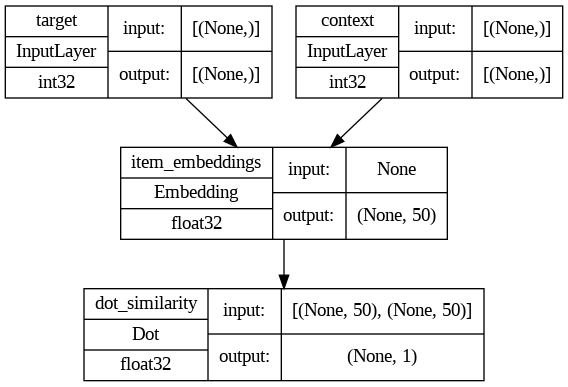

In [17]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [18]:
with tf.device('/cpu:0'):
    history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
1220/1220 [==============================] - 29s 23ms/step - loss: 2.2615
Epoch 2/10
1220/1220 [==============================] - 32s 26ms/step - loss: 1.9601
Epoch 3/10
1220/1220 [==============================] - 29s 24ms/step - loss: 1.7693
Epoch 4/10
1220/1220 [==============================] - 29s 24ms/step - loss: 1.7478
Epoch 5/10
1220/1220 [==============================] - 28s 23ms/step - loss: 1.7374
Epoch 6/10
1220/1220 [==============================] - 28s 23ms/step - loss: 1.7373
Epoch 7/10
1220/1220 [==============================] - 28s 23ms/step - loss: 1.7318
Epoch 8/10
1220/1220 [==============================] - 28s 23ms/step - loss: 1.7306
Epoch 9/10
1220/1220 [==============================] - 29s 24ms/step - loss: 1.7302
Epoch 10/10
1220/1220 [==============================] - 29s 23ms/step - loss: 1.7305


Percentage drop in training loss after 10 epochs = 23.479490455798107%


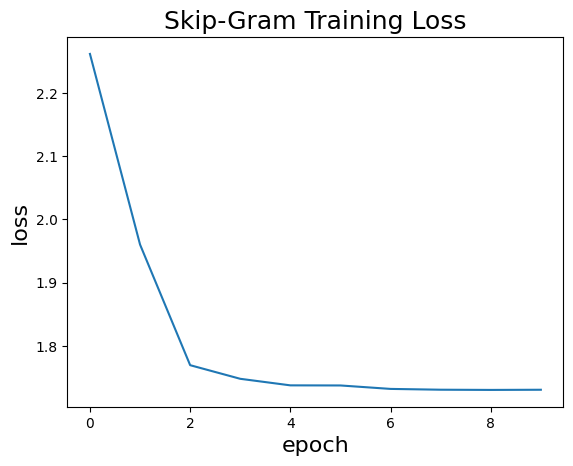

In [19]:
a = history.history["loss"][0]
b = history.history["loss"][9]
pct_drop = 100 * np.abs(a - b) / a
print(f"Percentage drop in training loss after 10 epochs = {pct_drop}%")

plt.plot(history.history["loss"])
plt.ylabel("loss", fontsize = 16)
plt.xlabel("epoch", fontsize = 16)
plt.title("Skip-Gram Training Loss", fontsize = 18)
plt.show()

# Analyze Learnt Embeddings: Which Facebook pages are similar?

In [20]:
query_tiny = [
    "Brooklyn Nine-Nine",
]

queries = [
    "Glee",
    "United States Air Force",
    "NASA’s Curiosity Mars Rover",
    "Barack Obama"
]

# SELECT which queries #
# queries = query_tiny

### Your Code Here

from sklearn.metrics.pairwise import cosine_similarity

# Get the embedding weights from the model
embedding_layer = model.get_layer('item_embeddings')
embedding_weights = embedding_layer.get_weights()[0]

# compute similarities between query embeddings and all other embeddings
top5s = []
for page in queries:

    id = name_to_id(page)

    page_id = vocabulary_lookup[id]
    print(f"query page name = {page}, id = {page_id}")

    embedding = embedding_weights[page_id]
    print("\nHint 1: The L2 norm of the embedding vector for 'Brooklyn Nine Nine'")
    print(f"on Tiny graph should be about 1.37. Our results show {np.linalg.norm(embedding, 2)}")

    similarities = cosine_similarity([embedding], embedding_weights)

    # get 5-nearest-neighbors (excluding the query itself)

    top_6 = tf.math.top_k(similarities, k = 6)
    top_6_id = top_6.indices.numpy()[0]
    print("\nNearest neighbors including self:", top_6_id)

    # top_5_id = np.setdiff1d(top_6_id, [page_id])
    top_5_id = top_6_id[1:6]
    print("\n5-nearest-neighbors:", top_5_id)

    top5s.append(top_5_id)

print(f"\nList of 5-n-ns: {top5s}")
### Your Code End

query page name = Glee, id = 2386

Hint 1: The L2 norm of the embedding vector for 'Brooklyn Nine Nine'
on Tiny graph should be about 1.37. Our results show 2.543515205383301

Nearest neighbors including self: [2386 2229 1451  725 2610 3003]

5-nearest-neighbors: [2229 1451  725 2610 3003]
query page name = United States Air Force, id = 3857

Hint 1: The L2 norm of the embedding vector for 'Brooklyn Nine Nine'
on Tiny graph should be about 1.37. Our results show 2.175950765609741

Nearest neighbors including self: [3857  956 2496 3160 3926  339]

5-nearest-neighbors: [ 956 2496 3160 3926  339]
query page name = NASA’s Curiosity Mars Rover, id = 1934

Hint 1: The L2 norm of the embedding vector for 'Brooklyn Nine Nine'
on Tiny graph should be about 1.37. Our results show 2.5159640312194824

Nearest neighbors including self: [1934 2088 3539 1000 1024   22]

5-nearest-neighbors: [2088 3539 1000 1024   22]
query page name = Barack Obama, id = 1611

Hint 1: The L2 norm of the embedding vect

In [21]:
for idx, title in enumerate(queries):
    print(title)
    print("".rjust(len(title), "-"))

    ### Your Code Here
    # similar_tokens = []   # TODO: Fill in with your recommendations for the given title
    similar_tokens = top5s[idx]

    ### Your Code End
    for token in similar_tokens:
        similar_pageId = vocabulary[token]
        similar_title = id_to_name(similar_pageId) +  ": " +  targets_df[targets_df['id'] == similar_pageId]['page_type'].values[0]
        print(f"- {similar_title}")
    print()

Glee
----
- Matthew Guy: politician
- The Grinder: tvshow
- Hell's Kitchen: tvshow
- Making History: tvshow
- The Rhode Show: tvshow

United States Air Force
-----------------------
- United States Navy Band: government
- U.S. Army Combined Arms Center: government
- Joint Base Lewis-McChord: government
- Armée de Terre: government
- Markus Paschke: politician

NASA’s Curiosity Mars Rover
---------------------------
- Anne Arundel County Department of Health: government
- Feds Feed Families: government
- Kepler and K2 Missions: government
- National Institute of Allergy and Infectious Diseases (NIAID): government
- MedlinePlus en español: government

Barack Obama
------------
- Marcos Peña: politician
- Patricia Bullrich: politician
- PEO Soldier: government
- Utah Division of Emergency Management: government
- Canada Keep Exploring: company

